<div style="float:right; padding-top: 15px; padding-right: 15px">
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whitebox-public.s3.eu-west-1.amazonaws.com/png/AF-logo-rgb-transparente-02.png" width=250>
        </a>
    </div>
</div>

In order to run this notebook, the following libraries should be installed:
- pandas
- matplotlib
- qiskit-machine-learning

# 0. data loading

In [1]:
import pandas as pd

data_url = 'https://datamarket.es/media/samples/catastro-sample.csv'

df = pd.read_csv(data_url)

df.head()

area     autonomous_region   description has_doorman has_garden has_lift  \
0    130  Madrid, Comunidad de  Esc.1 Bajo B        True      False     True   
1    130  Madrid, Comunidad de    Esc.7 3º B        True      False     True   
2     82  Madrid, Comunidad de         2º 03       False      False    False   
3    165  Madrid, Comunidad de      Inmueble       False       True    False   
4  14144  Madrid, Comunidad de      Inmueble         NaN        NaN      NaN   

  has_parking has_storage has_swimming_pool  is_residential  ...  \
0        True        True             False            True  ...   
1        True        True             False            True  ...   
2       False       False             False            True  ...   
3       False        True             False            True  ...   
4         NaN         NaN               NaN           False  ...   

                   street  area_item  floor typology_item  door total_floors  \
0  Calle Valle Del Baztan         11     -1           AAP     5          5.0   
1  Calle Valle Del Baztan          4     -1           AAL   111          5.0   
2     Calle Santa Juliana         77     02             V    03          6.0   
3    Calle Sicomoro (Del)         58     01             V    01          3.0   
4            Calle Alcala       1040     02             P    01          NaN   

                town typology  year_built shared_quota  
0  Torrejón de Ardoz        V      2012.0       0.0006  
1  Torrejón de Ardoz        V      2012.0       0.0002  
2             Madrid        V      1925.0       0.0452  
3           Móstoles        V      2006.0       0.3515  
4             Madrid        O         NaN          NaN  

[5 rows x 27 columns]

In [2]:
df.dtypes

area                     int64
autonomous_region       object
description             object
has_doorman             object
has_garden              object
has_lift                object
has_parking             object
has_storage             object
has_swimming_pool       object
is_residential            bool
latitude               float64
longitude              float64
neighbors_per_floor      int64
number                  object
postal_code              int64
province                object
reference               object
street                  object
area_item                int64
floor                   object
typology_item           object
door                    object
total_floors           float64
town                    object
typology                object
year_built             float64
shared_quota           float64
dtype: object

In [3]:
df.shape

(60000, 27)

# 1. data preparation

In [4]:
feature_cols = [
    'province',
    'area',
    'year_built',
]

categorical_cols = [
    'province',
]

target_col = 'has_swimming_pool'

In [5]:
df = df[feature_cols + [target_col]]

df.head()

province   area  year_built has_swimming_pool
0   Madrid    130      2012.0             False
1   Madrid    130      2012.0             False
2   Madrid     82      1925.0             False
3   Madrid    165      2006.0             False
4   Madrid  14144         NaN               NaN

In [6]:
df.isna().sum()

province                0
area                    0
year_built           6608
has_swimming_pool    6608
dtype: int64

In [7]:
df.dropna(inplace=True)

len(df)

53392

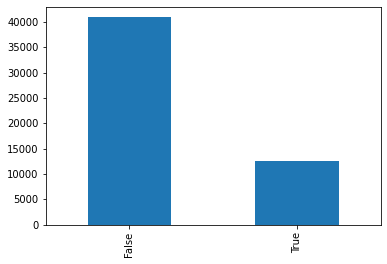

In [8]:
df['has_swimming_pool'].value_counts().plot.bar();

In [9]:
df['has_swimming_pool'].value_counts()

False    40903
True     12489
Name: has_swimming_pool, dtype: int64

In [10]:
df_pos = df[df['has_swimming_pool'] == 1]
df_neg = df[df['has_swimming_pool'] == 0]

df = pd.concat((df_pos, df_neg.sample(len(df_pos), random_state=42)))

df['has_swimming_pool'].value_counts()

True     12489
False    12489
Name: has_swimming_pool, dtype: int64

In [11]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

df[categorical_cols] = enc.fit_transform(df[categorical_cols])

df.head()

province  area  year_built has_swimming_pool
5        7.0   104      2004.0              True
10       7.0   170      2005.0              True
14       7.0    96      2004.0              True
15       7.0   261      2019.0              True
19       7.0   261      1985.0              True

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[feature_cols] = scaler.fit_transform(df[feature_cols])

df.head()

province      area  year_built has_swimming_pool
5    0.07848 -0.071643    0.393391              True
10   0.07848 -0.032883    0.416432              True
14   0.07848 -0.076341    0.393391              True
15   0.07848  0.020559    0.739014              True
19   0.07848  0.020559   -0.044399              True

In [13]:
n_samples = 1000

df = df.sample(n_samples, random_state=42)

df.shape

(1000, 4)

In [14]:
from sklearn.model_selection import train_test_split

X = df[feature_cols]
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750, 3), (250, 3), (750,), (250,))

# 2. modeling

## 2.1 Quantum

In [15]:
from qiskit import BasicAer

backend = BasicAer.get_backend('statevector_simulator')

backend

<StatevectorSimulatorPy('statevector_simulator')>

In [16]:
from qiskit.utils import QuantumInstance

quantum_instance = QuantumInstance(backend)

quantum_instance

In [17]:
num_qubits = len(feature_cols)

num_qubits

3

### 2.1.1 QSVC

In [18]:
from qiskit.circuit.library import ZFeatureMap

feature_map = ZFeatureMap(feature_dimension=num_qubits)

feature_map

In [19]:
from qiskit_machine_learning.kernels import QuantumKernel

qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

qkernel

In [20]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=qkernel)

qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f56a521aa10>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

### 2.1.2 QNNC

In [21]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN

qnn_architecture = TwoLayerQNN(num_qubits, quantum_instance=quantum_instance)

qnn_architecture

In [22]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title('Objective function vs iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Objective function')
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [23]:
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA

qnnc = NeuralNetworkClassifier(qnn_architecture, optimizer=COBYLA(maxiter=50), callback=callback_graph)

qnnc

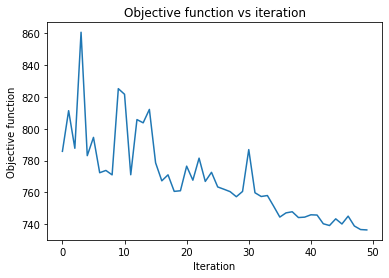

In [24]:
objective_func_vals = []

y_train_qnnc = y_train.copy()
y_train_qnnc[y_train_qnnc == 0] = -1

qnnc.fit(X_train, y_train_qnnc.values)

## 2.2 classical

### 2.2.1 SVC

In [25]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

SVC()

### 2.2.2 MLP

In [26]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

mlp.fit(X_train, y_train)

/home/ubuntu/miniconda3/envs/quantum_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier()

# 3. Benchmarking

In [27]:
from sklearn.metrics import classification_report

model_dict = {
    'QSVC': qsvc,
    'QNNC': qnnc,
    'SVC': svc,
    'MLP': mlp,
}

for model_id, model in model_dict.items():
    print(f'{model_id} report:')
    y_predict = model.predict(X_test)
    
    if model_id == 'QNNC':
        y_predict[y_predict == -1] = 0
        
    print(classification_report(y_test, y_predict))


QSVC report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.68       114
           1       0.72      0.77      0.75       136

    accuracy                           0.72       250
   macro avg       0.71      0.71      0.71       250
weighted avg       0.72      0.72      0.71       250

QNNC report:
              precision    recall  f1-score   support

           0       0.43      0.46      0.45       114
           1       0.52      0.49      0.51       136

    accuracy                           0.48       250
   macro avg       0.48      0.48      0.48       250
weighted avg       0.48      0.48      0.48       250

SVC report:
              precision    recall  f1-score   support

           0       0.72      0.58      0.64       114
           1       0.70      0.81      0.75       136

    accuracy                           0.70       250
   macro avg       0.71      0.69      0.69       250
weighted avg       0.71      0.70   

<div style="padding-top: 25px; float: right">
    <div>
        <i>&nbsp;&nbsp;© Copyright by</i>
    </div>
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whitebox-public.s3.eu-west-1.amazonaws.com/png/AF-logo-rgb-transparente-08.png" width=125>
        </a>
    </div>
</div>